Instalacion de dependencias

In [1]:
pip install pandas matplotlib seaborn scikit-learn openpyxl graphviz

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl

In [4]:
file = 'Pruebas experimentales del rotavapor RCL.xlsx'
sheet = 'Datos'

try:
    df = pd.read_excel(file, sheet_name=sheet)
except FileNotFoundError:
    print(f"Error: The file '{file}' was not found.")
    exit()
except Exception as e:
    print(f"An error occurred while reading the file: {e}")
    exit()

tabla = df.iloc[12:, 2:]
tabla.columns = df.iloc[11, 2:]
tabla.reset_index(drop=True, inplace=True)

# Tasa de evaporación = 6446 - 0,292 X1 - 52,58 X2 - 0,206 X3 + 0,34 X4 - 817 X5 + 674 X6 - 416 X7
tabla['Tasa de evaporación'] = (
    6446 -
    0.292 * tabla['X1'] -
    52.58 * tabla['X2'] -
    0.206 * tabla['X3'] +
    0.34 * tabla['X4'] -
    817 * tabla['X5'] +
    674 * tabla['X6'] -
    416 * tabla['X7']
)

#Cambiar nombre de las columnas
# X1	Temperatura del baño calefactor (°C)
# X2	Tiempo de residencia (h)
# X3	Velocidad de rotación (rpm)
# X4	Temperatura del enfriamiento (°C)
# X5	Corriente baño Calefactor (A)
# X6	Corriente agitación (A)
# X7	Corriente de enfriamiento (A)

print("Columnas originales:", tabla.columns.tolist())
print("Número de columnas:", len(tabla.columns))

# Cambiar nombres de las columnas (9 columnas en total)
tabla.columns = [
    'C_calefactor',
    'h_residencia', 
    'rpm_rotacion',
    'C_enfriamiento',
    'A_calefactor',
    'A_agitacion',
    'A_enfriamiento',
    'Masa_agua',
    'Tasa_de_evaporacion'
]

print("Nuevos nombres de columnas:", tabla.columns.tolist())
print(tabla.head())

Columnas originales: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Masa Agua', 'Tasa de evaporación']
Número de columnas: 9
Nuevos nombres de columnas: ['C_calefactor', 'h_residencia', 'rpm_rotacion', 'C_enfriamiento', 'A_calefactor', 'A_agitacion', 'A_enfriamiento', 'Masa_agua', 'Tasa_de_evaporacion']
  C_calefactor h_residencia rpm_rotacion C_enfriamiento A_calefactor  \
0           80            3          200              8         4.26   
1           60            2          150              8         4.33   
2           60            1          200              8         4.33   
3           70            2          200              8         4.28   
4           70            1          250              8         4.28   

  A_agitacion A_enfriamiento Masa_agua Tasa_de_evaporacion  
0       0.052           6.54   189.814              60.408  
1        0.04           6.54   102.816               63.85  
2       0.052           6.54    78.214             114.218  
3       0.052        

In [5]:
features = [
    'C_calefactor',
    'h_residencia', 
    'rpm_rotacion',
    'C_enfriamiento',
    'A_calefactor',
    'A_agitacion',
    'A_enfriamiento',
]
target = "Etiqueta"

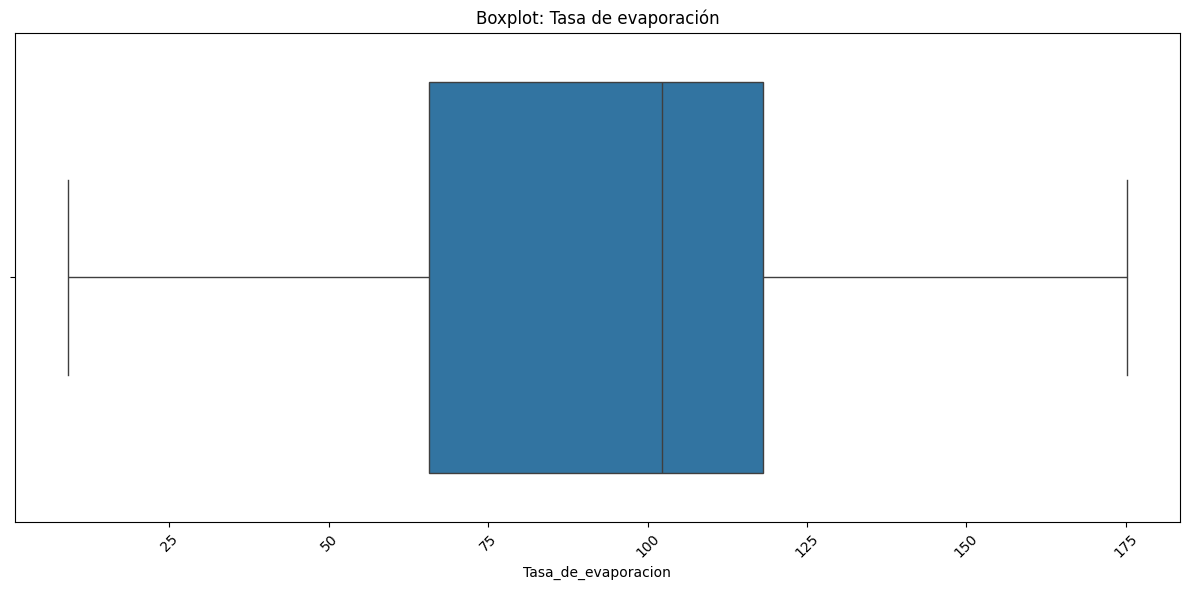

In [6]:
# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=tabla["Tasa_de_evaporacion"], orient='h')
plt.title('Boxplot: Tasa de evaporación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Sacar la mediana de la tasa de evaporación
mediana = tabla["Tasa_de_evaporacion"].median()
print(f"Mediana de la tasa de evaporación: {mediana}")

# Sacar la desviación estándar de la tasa de evaporación
desv = tabla["Tasa_de_evaporacion"].std()    
print(f"Desviación estándar de la tasa de evaporación: {desv}")

Mediana de la tasa de evaporación: 102.27700000000073
Desviación estándar de la tasa de evaporación: 38.26168156915431


In [8]:
def etiqueta(valor):
    if valor < mediana - desv:
        return "Bajo"
    elif valor > mediana + desv:
        return "Alto"
    else:
        return "Medio"

tabla["Etiqueta"] = tabla["Tasa_de_evaporacion"].apply(etiqueta)
print(tabla[["Tasa_de_evaporacion", "Etiqueta"]])

    Tasa_de_evaporacion Etiqueta
0                60.408     Bajo
1                 63.85     Bajo
2               114.218    Medio
3                99.568    Medio
4               158.024     Alto
..                  ...      ...
107             124.468    Medio
108              89.458    Medio
109             159.964     Alto
110              35.046     Bajo
111              78.626    Medio

[112 rows x 2 columns]


# Arbol de decision

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(
    tabla[features],
    tabla[target],
    test_size=0.2,
    random_state=42
)

classifier = DecisionTreeClassifier(criterion="gini" ,random_state=42)
classifier.fit(X_train, y_train)

y_pred_train = classifier.predict(X_train)
y_pred_test = classifier.predict(X_test)

In [10]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

accuracy = metrics.accuracy_score(y_train, y_pred_train)
print(f"Accuracy on training set: {accuracy:.2f}")
cm = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_train, y_pred_train))

Accuracy on training set: 1.00
Confusion Matrix:
[[16  0  0]
 [ 0 23  0]
 [ 0  0 50]]
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00        16
        Bajo       1.00      1.00      1.00        23
       Medio       1.00      1.00      1.00        50

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



In [11]:
y_pred = classifier.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print(classification_report(y_test, y_pred))

Accuracy on test set: 1.00
Confusion Matrix:
[[ 4  0  0]
 [ 0  5  0]
 [ 0  0 14]]
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00         4
        Bajo       1.00      1.00      1.00         5
       Medio       1.00      1.00      1.00        14

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23



In [13]:
import graphviz
from sklearn import tree
feat_names = X_train.columns.tolist()
tree.export_graphviz(classifier,filled=True, rounded=True, out_file="dt_rp_tree.dot",
                    feature_names=feat_names, class_names=classifier.classes_.astype(str))

# Random Forest

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

def randomForest(data):
    X = data[features]
    y = data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    print("Matriz de Confusión:")
    print(confusion_matrix(y_test, y_pred))
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    try:
        auc = roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr')
        print("AUC-ROC (One vs Rest):", auc)
    except Exception as e:
        print(f"No se pudo calcular AUC-ROC: {e}")

    # Evaluar importancia de las variables
    importances = rf.feature_importances_
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)
    print("\nImportancia de Variables:")
    print(feature_importance)

    # Graficar importancia de las variables
    plt.figure(figsize=(8,6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
    plt.xlabel('Importancia')
    plt.title('Importancia de Variables en el Modelo Random Forest')
    plt.gca().invert_yaxis()
    plt.show()
    
    return rf

Matriz de Confusión:
[[ 6  0  0]
 [ 0  7  2]
 [ 0  0 19]]

Reporte de Clasificación:
              precision    recall  f1-score   support

        Alto       1.00      1.00      1.00         6
        Bajo       1.00      0.78      0.88         9
       Medio       0.90      1.00      0.95        19

    accuracy                           0.94        34
   macro avg       0.97      0.93      0.94        34
weighted avg       0.95      0.94      0.94        34

AUC-ROC (One vs Rest): 1.0

Importancia de Variables:
          Feature  Importance
1    h_residencia    0.584790
0    C_calefactor    0.115579
4    A_calefactor    0.094900
2    rpm_rotacion    0.074290
5     A_agitacion    0.063859
6  A_enfriamiento    0.040219
3  C_enfriamiento    0.026364


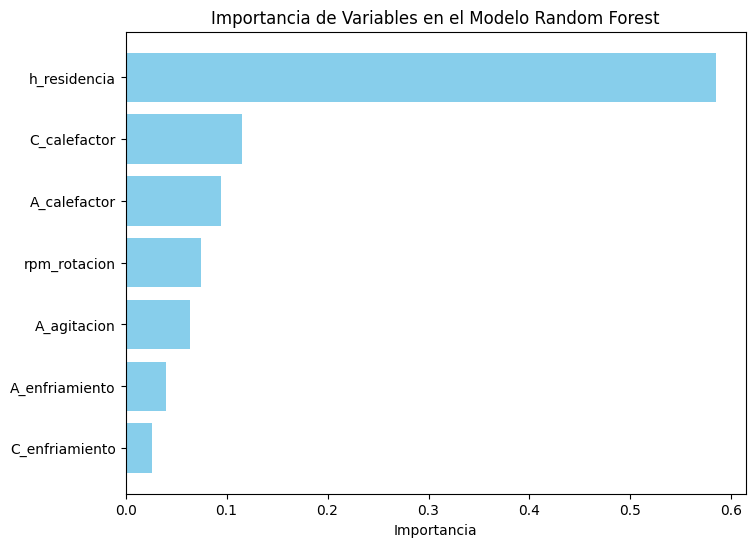

RandomForestClassifier(class_weight='balanced', random_state=42)

In [15]:
randomForest(tabla)